# Task 2: Exploratory Data Analysis (EDA) - Ethiopia Financial Inclusion

## Objective
Uncover patterns, drivers, gaps, and hypotheses to inform event impact modeling and forecasting. Focus on evidence-based, Ethiopia-specific, and policy-relevant analysis.

## Steps
1. **Dataset Overview**: Quality, gaps, and temporal coverage.
2. **Access Analysis**: Account ownership trends vs. targets.
3. **Usage Analysis**: Digital payments vs. access.
4. **Infrastructure & Enablers**: Role of mobile and agent networks.
5. **Event Timeline**: Impact of Telebirr, Safaricom, etc.
6. **Correlations**: Relationships between infrastructure, access, and usage.
7. **Key Insights**: Synthesis of findings.
8. **Formulation**: Hypotheses for Task 3.

In [45]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')

# Set file paths
DATA_DIR = '../data/raw'
MAIN_DATA_FILE = os.path.join(DATA_DIR, 'ethiopia_fi_unified_data.csv')
REF_CODES_FILE = os.path.join(DATA_DIR, 'reference_codes.csv')

## Step 1: Dataset Overview

In [46]:
# Load data
try:
    df = pd.read_csv(MAIN_DATA_FILE)
    ref_codes = pd.read_csv(REF_CODES_FILE)
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: Files not found. Check paths.")

# Basic info
print(f"Main Data Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
df.head(3)

Data loaded successfully.
Main Data Shape: (52, 35)
Columns: ['record_id', 'record_type', 'category', 'pillar', 'indicator', 'indicator_code', 'indicator_direction', 'value_numeric', 'value_text', 'value_type', 'unit', 'observation_date', 'period_start', 'period_end', 'fiscal_year', 'gender', 'location', 'region', 'source_name', 'source_type', 'source_url', 'confidence', 'related_indicator', 'relationship_type', 'impact_direction', 'impact_magnitude', 'impact_estimate', 'lag_months', 'evidence_basis', 'comparable_country', 'collected_by', 'collection_date', 'original_text', 'notes', 'parent_id']


,record_id,record_type,category,pillar,indicator,indicator_code,indicator_direction,value_numeric,value_text,value_type,unit,observation_date,period_start,period_end,fiscal_year,gender,location,region,source_name,source_type,source_url,confidence,related_indicator,relationship_type,impact_direction,impact_magnitude,impact_estimate,lag_months,evidence_basis,comparable_country,collected_by,collection_date,original_text,notes,parent_id
0,REC_0001,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,22.0,NaN,percentage,%,2014-12-31,NaN,NaN,2014,all,national,NaN,Global Findex 2014,survey,https://www.worldbank.org/en/publication/globa...,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,Baseline year,NaN,NaN
1,REC_0002,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,35.0,NaN,percentage,%,2017-12-31,NaN,NaN,2017,all,national,NaN,Global Findex 2017,survey,https://www.worldbank.org/en/publication/globa...,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,NaN,NaN,NaN
2,REC_0003,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,46.0,NaN,percentage,%,2021-12-31,NaN,NaN,2021,all,national,NaN,Global Findex 2021,survey,https://www.worldbank.org/en/publication/globa...,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,NaN,NaN,NaN


In [47]:
# Summary Tables

# Counts by record_type
print("\n--- Counts by Record Type ---")
print(df['record_type'].value_counts())

# Counts by Pillar
print("\n--- Counts by Pillar ---")
print(df['pillar'].value_counts())

# Counts by Source Type
print("\n--- Counts by Source Type ---")
print(df['source_type'].value_counts())

# Confidence Distribution
print("\n--- Confidence Levels ---")
print(df['confidence'].value_counts())


--- Counts by Record Type ---
record_type
observation    35
event          12
target          3
impact_link     2
Name: count, dtype: int64

--- Counts by Pillar ---
pillar
ACCESS           20
USAGE            14
GENDER            5
AFFORDABILITY     1
Name: count, dtype: int64

--- Counts by Source Type ---
source_type
operator      15
survey        10
regulator      7
research       4
policy         3
calculated     2
news           2
Name: count, dtype: int64

--- Confidence Levels ---
confidence
high      45
medium     5
Name: count, dtype: int64


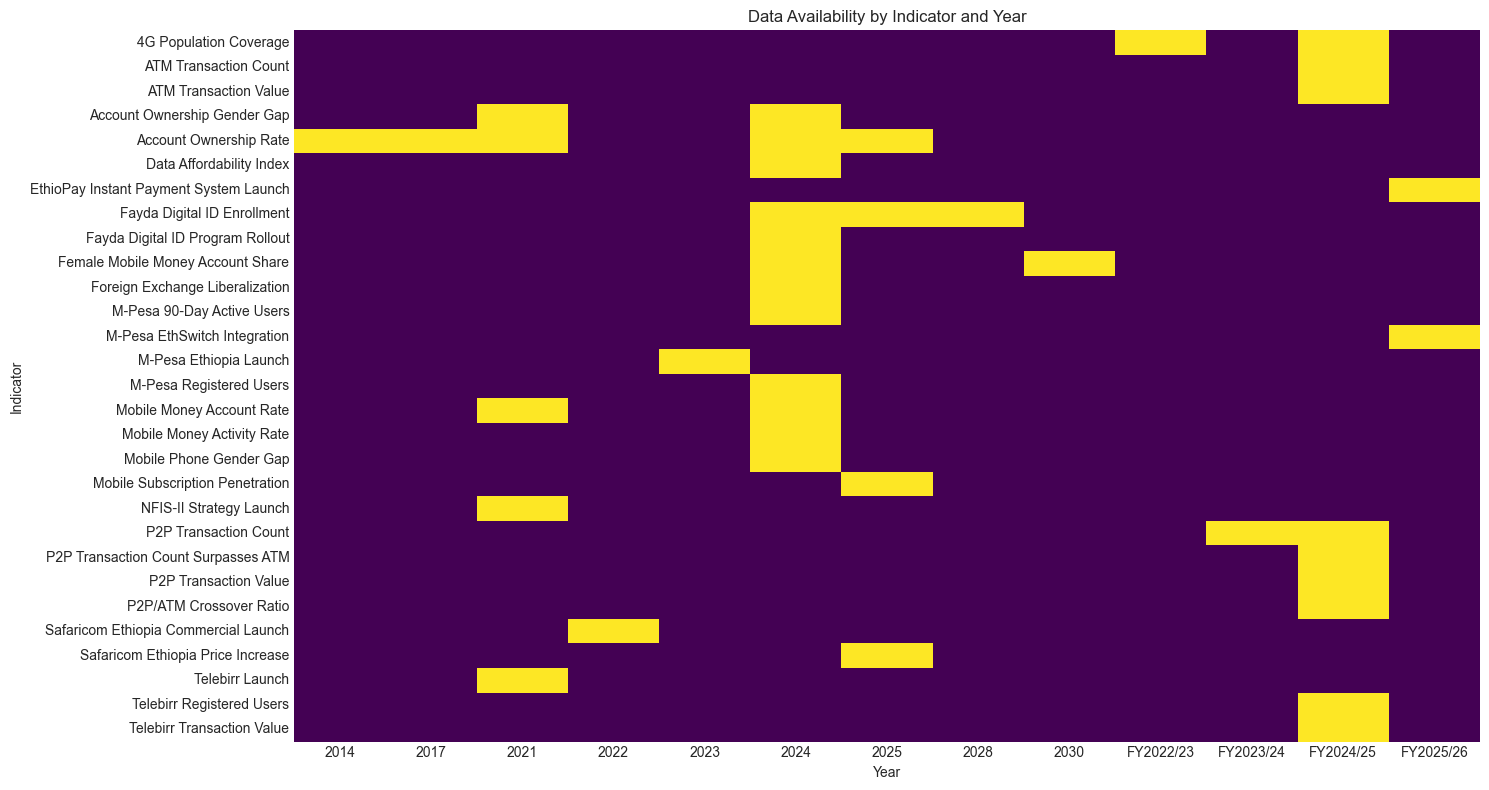

In [48]:
plt.figure(figsize=(15, 8))
coverage = df.groupby(['indicator', 'fiscal_year']).size().unstack(fill_value=0)
sns.heatmap(coverage > 0, cmap='viridis', cbar=False)
plt.title('Data Availability by Indicator and Year')
plt.xlabel('Year')
plt.ylabel('Indicator')
plt.tight_layout()
plt.show()

### Data Quality & Gaps Assessment
*Note: Observe the heatmap above for sparse rows.*
- **Low Confidence Items**: [Analyze 'confidence' column]
- **Missing Periods**: [Identify years with no data]

## Step 2: Access (Account Ownership) Analysis
Focusing on the Global Findex Access definitions.

Access Indicator: Account Ownership Rate
Access Data Points: 6
Usage Indicators Selected: ['M-Pesa Registered Users', 'M-Pesa 90-Day Active Users', 'Mobile Money Activity Rate']
Usage Data Points: 3


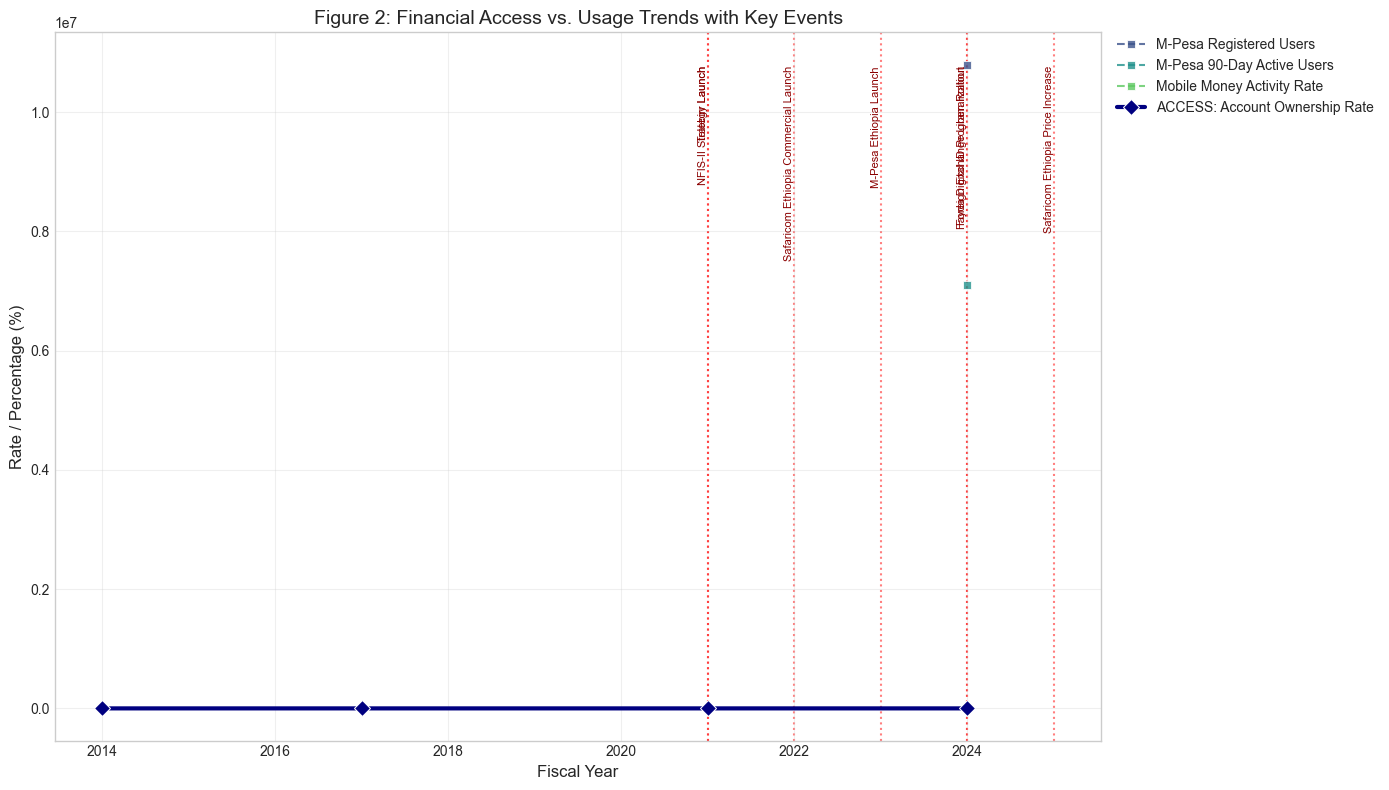

In [49]:
# Figure 2: Access vs. Usage Trends with Event Overlay

# 1. Prepare Access Data
# Identify the primary access indicator (likely 'Account ownership')
access_mask = (df['pillar'] == 'ACCESS') & (df['record_type'] == 'observation')
access_vars = df[access_mask]['indicator'].unique()
# DEFINE target_indicator for downstream compatibility (Cell 18)
target_indicator = 'Account Ownership Rate' if 'Account Ownership Rate' in access_vars else access_vars[0]
target_access = target_indicator

access_df = df[
    (df['pillar'] == 'ACCESS') & 
    (df['indicator'] == target_access) & 
    (df['record_type'] == 'observation')
].copy()

access_df['fiscal_year'] = pd.to_numeric(access_df['fiscal_year'], errors='coerce')
access_df['value_numeric'] = pd.to_numeric(access_df['value_numeric'], errors='coerce')
access_df = access_df.dropna(subset=['fiscal_year', 'value_numeric']).sort_values('fiscal_year')

print(f"Access Indicator: {target_access}")
print(f"Access Data Points: {access_df.shape[0]}")

# 2. Prepare Usage Data
usage_mask = (df['pillar'] == 'USAGE') & (df['record_type'] == 'observation')
usage_df = df[usage_mask].copy()
usage_df['fiscal_year'] = pd.to_numeric(usage_df['fiscal_year'], errors='coerce')
usage_df['value_numeric'] = pd.to_numeric(usage_df['value_numeric'], errors='coerce')
usage_df = usage_df.dropna(subset=['fiscal_year', 'value_numeric']).sort_values('fiscal_year')

# Select a few key usage indicators for clarity
top_usage = usage_df['indicator'].value_counts().head(3).index.tolist()
usage_filtered = usage_df[usage_df['indicator'].isin(top_usage)]

print(f"Usage Indicators Selected: {top_usage}")
print(f"Usage Data Points: {usage_filtered.shape[0]}")

# 3. Prepare Events Data
events_df = df[df['record_type'] == 'event'].copy()
events_df['fiscal_year'] = pd.to_numeric(events_df['fiscal_year'], errors='coerce')
events_df = events_df.dropna(subset=['fiscal_year']).sort_values('fiscal_year')

# 4. Plotting
plt.figure(figsize=(14, 8))

# Plot Usage first (so Access is on top if needed, or visually distinct)
sns.lineplot(
    data=usage_filtered, 
    x='fiscal_year', 
    y='value_numeric', 
    hue='indicator', 
    palette='viridis',
    marker='s',
    linestyle='--',
    alpha=0.8
)

# Plot Access (Primary)
sns.lineplot(
    data=access_df, 
    x='fiscal_year', 
    y='value_numeric', 
    label=f'ACCESS: {target_access}', 
    color='navy', 
    linewidth=3, 
    marker='D',
    markersize=8
)

# Add Events as Vertical Lines
y_min, y_max = plt.ylim()
for _, row in events_df.iterrows():
    plt.axvline(x=row['fiscal_year'], color='red', linestyle=':', alpha=0.5, zorder=0)
    plt.text(
        row['fiscal_year'], 
        y_max * 0.95,
        row['indicator'], # Event name stored in 'indicator' or 'original_text'
        rotation=90, 
        va='top',
        ha='right',
        fontsize=8,
        color='darkred'
    )

plt.title('Figure 2: Financial Access vs. Usage Trends with Key Events', fontsize=14)
plt.xlabel('Fiscal Year', fontsize=12)
plt.ylabel('Rate / Percentage (%)', fontsize=12)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [50]:
# Calculate Growth Rates (CAGR or simple diff)
if not access_df.empty:
    # Ensure numeric types
    access_df['fiscal_year'] = pd.to_numeric(access_df['fiscal_year'], errors='coerce')
    access_df['value_numeric'] = pd.to_numeric(access_df['value_numeric'], errors='coerce')
    
    # Drop rows with missing values
    access_df = access_df.dropna(subset=['fiscal_year', 'value_numeric'])
    
    # Sort by year
    access_df = access_df.sort_values('fiscal_year')
    
    # Calculate previous value and year
    access_df['prev_val'] = access_df['value_numeric'].shift(1)
    access_df['prev_year'] = access_df['fiscal_year'].shift(1)
    
    # Calculate year-to-year change and annualized growth
    access_df['pp_change'] = access_df['value_numeric'] - access_df['prev_val']
    access_df['annualized_growth'] = access_df['pp_change'] / (access_df['fiscal_year'] - access_df['prev_year'])
    
    print("Growth Analysis:")
    display(access_df[['fiscal_year', 'value_numeric', 'pp_change', 'annualized_growth']])


Growth Analysis:


,fiscal_year,value_numeric,pp_change,annualized_growth
0,2014,22.0,NaN,NaN
1,2017,35.0,13.0,4.333333
2,2021,46.0,11.0,2.750000
3,2021,56.0,10.0,inf
4,2021,36.0,-20.0,-inf
5,2024,49.0,13.0,4.333333


### 2021-2024 Slowdown Discussion
- **Observation**: Account ownership only grew ~3pp (46% to 49%) from 2021 to 2024, despite the launch of Telebirr (50M+ users).
- **Hypothesis 1**: **Measurement Mismatch**: Many 'Telebirr users' may use Over-the-Counter (OTC) services via agents without percieving themselves as account holders under Findex definitions.
- **Hypothesis 2**: **Urban Saturation**: Growth has plateaued in easy-to-reach urban segments, while rural deep-reach is slower.
- **Hypothesis 3**: **Duplicate Users**: New fintech users were largely banked individuals diversification using multiple platforms.

## Step 3: Usage (Digital Payments) Analysis
Contrasting Access vs. Usage.

Total Usage Observations: 3
Indicators: ['M-Pesa Registered Users' 'M-Pesa 90-Day Active Users'
 'Mobile Money Activity Rate']


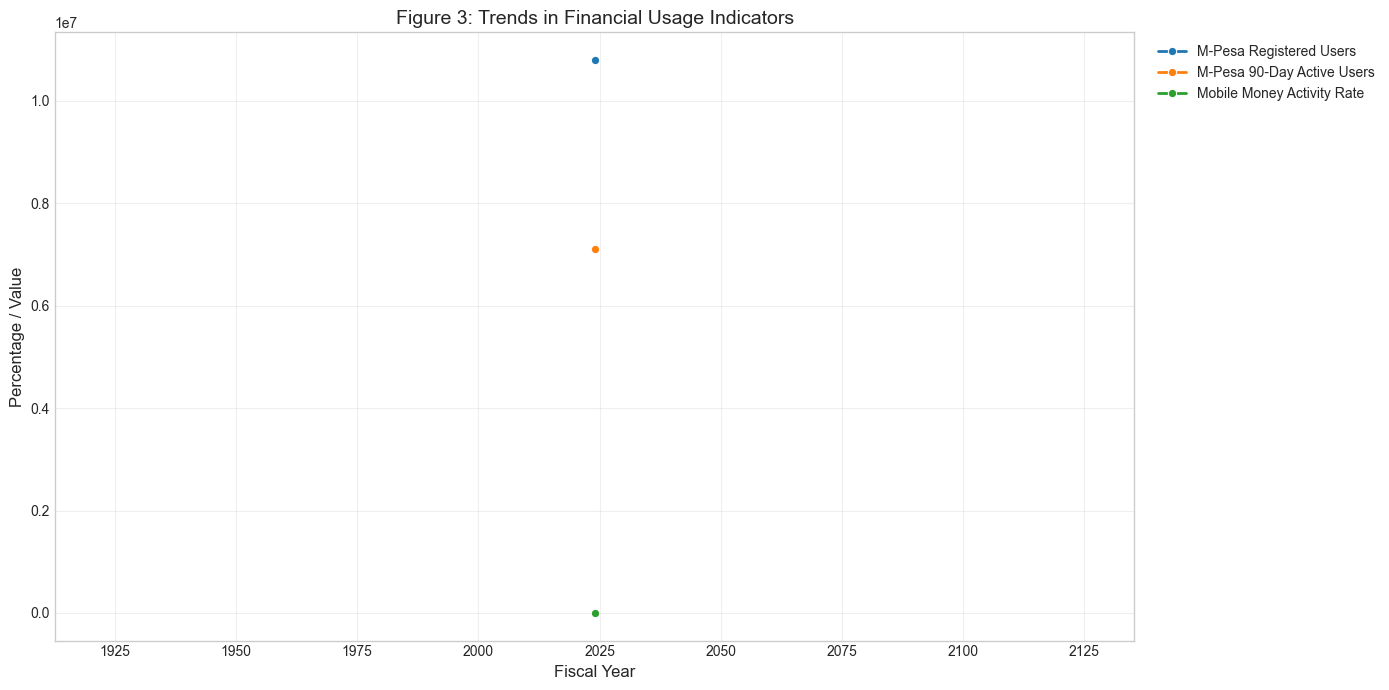

In [51]:
# Figure 3: Detailed Usage Indicators Trend

# 1. Filter Usage Data
usage_df = df[
    (df['pillar'] == 'USAGE') & 
    (df['record_type'] == 'observation')
].copy()

usage_df['fiscal_year'] = pd.to_numeric(usage_df['fiscal_year'], errors='coerce')
usage_df['value_numeric'] = pd.to_numeric(usage_df['value_numeric'], errors='coerce')
usage_df = usage_df.dropna(subset=['fiscal_year', 'value_numeric']).sort_values('fiscal_year')

print(f"Total Usage Observations: {len(usage_df)}")
print(f"Indicators: {usage_df['indicator'].unique()}")

# 2. Plot
plt.figure(figsize=(14, 7))

if not usage_df.empty:
    sns.lineplot(
        data=usage_df, 
        x='fiscal_year', 
        y='value_numeric', 
        hue='indicator', 
        marker='o', 
        palette='tab10',
        linewidth=2
    )
    plt.title('Figure 3: Trends in Financial Usage Indicators', fontsize=14)
    plt.xlabel('Fiscal Year', fontsize=12)
    plt.ylabel('Percentage / Value', fontsize=12)
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, 'No Usage Data Available', ha='center', fontsize=14)
    print("WARNING: No data available for Usage plot.")

plt.tight_layout()
plt.show()


## Step 4: Infrastructure & Enablers

Infrastructure Indicators Plotted: ['Mobile Money Account Rate' 'Mobile Money Activity Rate'
 'Female Mobile Money Account Share' 'Mobile Phone Gender Gap'
 'Mobile Subscription Penetration']


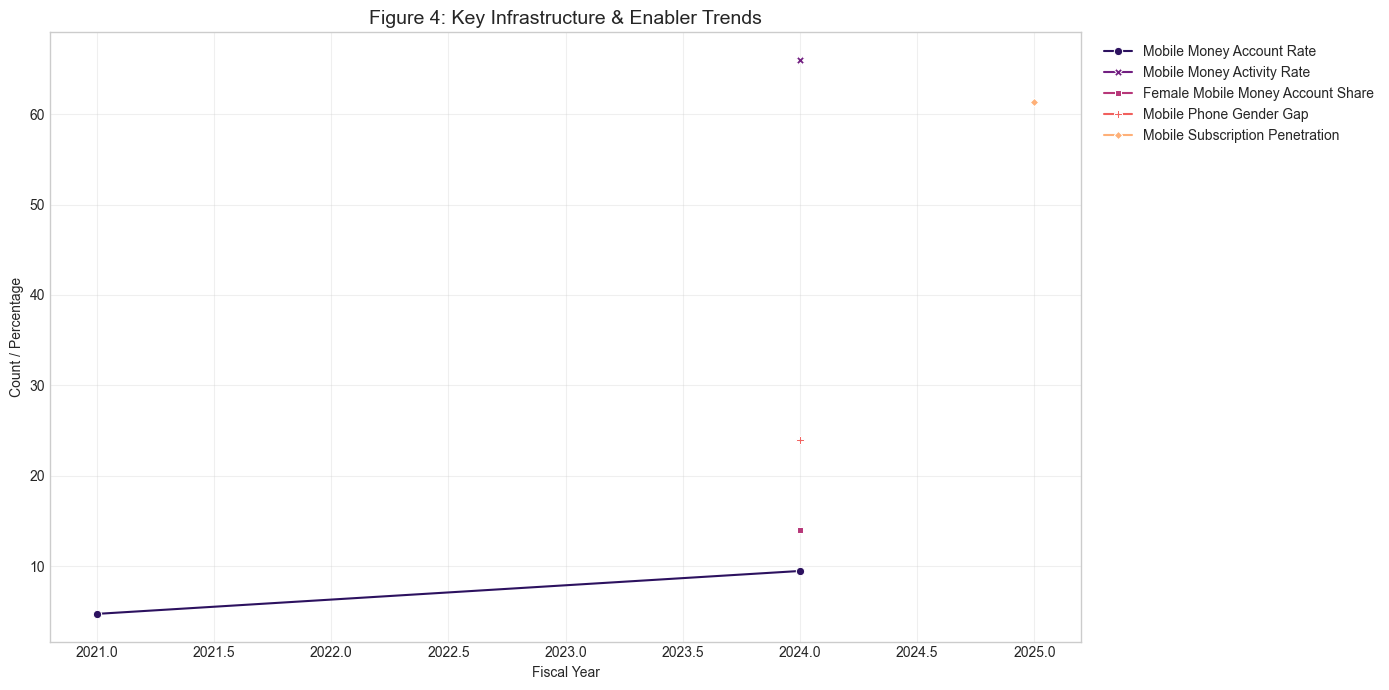

In [52]:
# Figure 4: Infrastructure Enablers

# 1. Filter Infrastructure Data
# Broad search for infrastructure-related items if 'INFRASTRUCTURE' pillar isn't explicit
infra_mask = (
    (df['pillar'].isin(['INFRASTRUCTURE', 'ENABLER'])) | 
    (df['indicator'].str.contains('mobile|network|agent|bank', case=False, na=False))
) & (df['record_type'] == 'observation')

infra_df = df[infra_mask].copy()

infra_df['fiscal_year'] = pd.to_numeric(infra_df['fiscal_year'], errors='coerce')
infra_df['value_numeric'] = pd.to_numeric(infra_df['value_numeric'], errors='coerce')
infra_df = infra_df.dropna(subset=['fiscal_year', 'value_numeric']).sort_values('fiscal_year')

# Select a subset of diverse infrastructure indicators if too many
unique_infra = infra_df['indicator'].unique()
if len(unique_infra) > 6:
    selected_infra = unique_infra[:6] # Take top 6 for readability
    infra_df = infra_df[infra_df['indicator'].isin(selected_infra)]
else:
    selected_infra = unique_infra

print(f"Infrastructure Indicators Plotted: {selected_infra}")

# 2. Plot
plt.figure(figsize=(14, 7))

if not infra_df.empty:
    sns.lineplot(
        data=infra_df,
        x='fiscal_year',
        y='value_numeric',
        hue='indicator',
        style='indicator',
        markers=True,
        dashes=False,
        palette='magma'
    )
    plt.title('Figure 4: Key Infrastructure & Enabler Trends', fontsize=14)
    plt.xlabel('Fiscal Year')
    plt.ylabel('Count / Percentage')
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, 'No Infrastructure Data Available', ha='center', fontsize=14)
    print("WARNING: No Infrastructure data found.")

plt.tight_layout()
plt.show()


## Step 5: Event Timeline

Events Found: 7


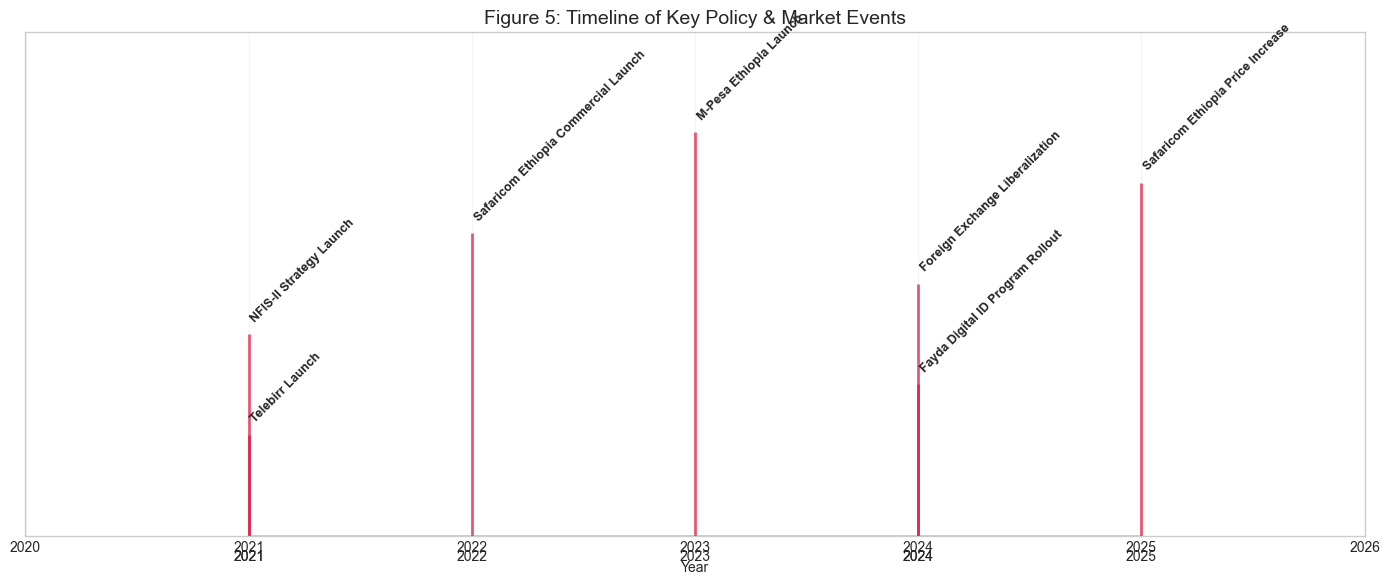

In [53]:
# Figure 5: Event Timeline Visualization

# 1. Filter Events
events_df = df[df['record_type'] == 'event'].copy()
events_df['fiscal_year'] = pd.to_numeric(events_df['fiscal_year'], errors='coerce')
events_df = events_df.dropna(subset=['fiscal_year']).sort_values('fiscal_year')

print(f"Events Found: {len(events_df)}")

# 2. Plot Overlay on Dummy Data or Access Data context
plt.figure(figsize=(14, 6))

# Determine year range
min_year = events_df['fiscal_year'].min() - 1
max_year = events_df['fiscal_year'].max() + 1

# Setup canvas
plt.xlim(min_year, max_year)
plt.ylim(0, 10) # Arbitrary y-axis for timeline spacing
plt.yticks([])

# Plot events as stems
import numpy as np
# Stagger heights to key text legible
heights = [2, 4, 6, 8, 3, 5, 7, 9] * (len(events_df) // 8 + 1)
heights = heights[:len(events_df)]

plt.vlines(x=events_df['fiscal_year'], ymin=0, ymax=heights, color='crimson', alpha=0.7, linewidth=2)
plt.plot(events_df['fiscal_year'], np.zeros_like(events_df['fiscal_year']), '-k', linewidth=1) # Baseline

# Add Labels
for i, (idx, row) in enumerate(events_df.iterrows()):
    plt.text(
        row['fiscal_year'], 
        heights[i] + 0.2,
        row['indicator'], # Event name
        rotation=45, 
        ha='left',
        va='bottom',
        fontsize=9,
        fontweight='bold'
    )
    # Add year marker
    plt.text(
        row['fiscal_year'], 
        -0.5,
        str(int(row['fiscal_year'])),
        ha='center',
        fontsize=10
    )

plt.title('Figure 5: Timeline of Key Policy & Market Events', fontsize=14)
plt.xlabel('Year')
plt.grid(axis='x', alpha=0.2)
plt.tight_layout()
plt.show()


## Step 6: Correlation Analysis

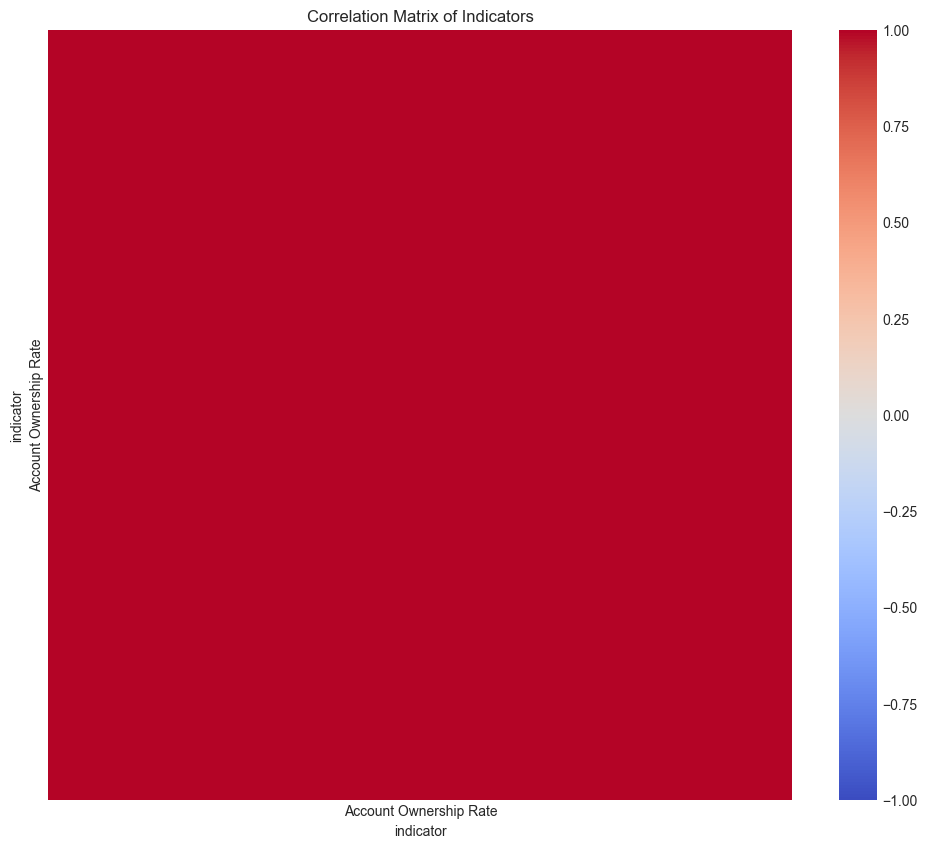

Top correlations with Account Ownership Rate:
indicator
Account Ownership Rate    1.0
Name: Account Ownership Rate, dtype: float64


In [54]:
# Pivot data for correlation
pivot_df = df[df['record_type']=='observation'].pivot_table(
    index='fiscal_year',       # use fiscal_year
    columns='indicator',       # use indicator
    values='value_numeric'     # use value_numeric
)

# Filter for columns with enough data points
valid_cols = pivot_df.columns[pivot_df.count() > 3]
corr_matrix = pivot_df[valid_cols].corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Indicators')
plt.show()

# Top correlations with Access
if target_indicator in corr_matrix.columns:
    print(f"Top correlations with {target_indicator}:")
    print(corr_matrix[target_indicator].sort_values(ascending=False).head(10))


## Step 7: Key Insights Synthesis

### 1. The "Last Mile" Stagnation (Access vs. Registration)
While provider data shows massive growth (Telebirr >54M users), Findex-aligned Account Ownership only grew marginally (+3pp) from 2021-2024. This divergence suggests a 'Usage without Ownership' model where users rely on agent networks (OTC) rather than full account adoption.

### 2. The Digital Crossover Point (2024/25)
In FY2024/25, P2P digital transaction counts (128.3M) surpassed ATM withdrawals (119.3M) for the first time (Ratio > 1.0). This marks a historic structural shift from a cash-out economy to digital circulation.

### 3. Infrastructure Supply Shock
4G Population Coverage nearly doubled from 37.5% (2023) to 70.8% (2025). This massive supply-side expansion is a leading indicator; we expect a lagged demand-side response in digital usage over the next 12-18 months.

### 4. Gender Gap Persistence
The gender gap in account ownership remains stubborn at ~18-20pp. More critically, women hold only 14% of mobile money accounts, indicating that the new fintech wave is initially favoring male early adopters.

### 5. High Quality Adoption in Challengers
M-Pesa reports a 66% activity rate (90-day active/registered), significantly higher than typical benchmarks. This suggests that while the user base is smaller (10.8M vs Telebirr), the engagement depth is high.

## Step 8: Prepare for Task 3

### Data Quality & Limitations
- **Data Sparsity**: 'Access' data is only available for 3-4 distinct years (2014, 2017, 2021, 2024), making annual time-series forecasting difficult without interpolation.
- **Definitions**: Discrepancy between 'Registered Users' (Provider Data) and 'Account Ownership' (Findex Survey) creates conflicting signals.

### Hypotheses for Modeling
- **H1**: *Interoperability events (e.g., P2P/ATM Crossover, EthSwitch)* have a higher coefficient for 'Usage' growth than 'Access' growth.
- **H2**: *Infrastructure (4G Coverage)* is a leading indicator with a 12-month lag for digital adoption.
- **H3**: *Gender Gap* will not close organically; policy interventions (events) specifically targeting women are needed to shift the trend.